<div style="position:relative; float:right"><img style="height:125px" src ="notebook_images/1200px-Star_wars2.svg.png" />
</div>
<div id="container" style="position:relative;">
<div style="float:left"><h1> Image Restoration with Deep Learning </h1></div>
<div id="container" style="position:relative;">
<div style="float:left"><h3> Episode III: Deep Learning Modeling - Advanced Convolutional Autoencoder</h3></div>
<div style="float:left"><h1> </h1></div>
</div>

Author: Elaheh Shakeri
<br>
Email: elahehshakeri3@gmail.com
<br>
Date: 12th December, 2022
<br>
Notebook 3 out of 4

## Table of Contents

[Introduction](#Introduction)
<br>
[Modeling](#Modeling)
<br>
[- Convolutional Autoencoder](#Convolutional-Autoencoder)
<br>
[- Evaluation Metrics](#Evaluation-Metrics)
<br>
[Loading, Preprocessing and Modeling 2% of the Dataset](#Loading,-Preprocessing-and-Modeling-2%-of-the-Dataset)
<br>
[Loading, Preprocessing and Modeling 12% of the Dataset](#Loading,-Preprocessing-and-Modeling-12%-of-the-Dataset)
<br>
[Conclusions](#Conclusions)

## Introduction

This notebook is the continuation of the second notebook. We will attempt to train a more complicated model in this notebook.

In this notebook due to the limited computational power and time, we only use the 2% and 12% sample datasets. This notebook was also ran on Google Colab, and was mounted on Google Drive where the datasets where stored.

In [2]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import os, sys
import cv2
import joblib
import glob
import math

# Importing tf tools
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose,AveragePooling2D, ReLU, MaxPooling2D,UpSampling2D, LeakyReLU, Dropout,BatchNormalization,Activation,Dense,Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from keras import backend as K

In [2]:
# Mounting our Colab notebook on google drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [3]:
# changing the directory of the notebook on to our google drive
cd '/content/gdrive/MyDrive/'

/content/gdrive/MyDrive


## Modeling

### Convolutional Autoencoder

We have increased the complexity of our model by adding more Convolutional, Pooling and Convolutional Transpose layers. The new model has 374,406 trainable parameters.

In [3]:
input = layers.Input(shape=(208, 384, 3))

# Encoder
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(input)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)

# Decoder
x = layers.Conv2DTranspose(128, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(3, (3, 3), activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(3, (3, 3), activation="relu", padding="same")(x)

autoencoder = Model(input, x)

2022-12-11 18:11:22.728700: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
# summary of the new model
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 208, 384, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 208, 384, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 104, 192, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 104, 192, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 52, 96, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 96, 64)        36928 

### Evaluation Metrics

Similar to the previous notbook, Mean Squared Error is our loss function and PSNR and SSIM are the model evaluation metrics.

- #### Mean Squared Error (MSE)

In [ ]:
def MSE(y_true, y_pred):
  '''
  INPUT: two images
  OUTPUT: the mean squared error between the input images
  '''
  err = np.sum((y_true.astype("float") - y_pred.astype("float")) ** 2) # sum of the squared difference between the pixels of the two images
  err /= float(y_true.shape[0] * y_true.shape[1]) # divide the error by the number pixels
  return err # returning error which is the MSE

- #### Peak Signal to Noise Ratio (PSNR)

In [4]:
def PSNR(y_true, y_pred):
  '''
  INPUT: two images
  OUTPUT: the PSNR of the two images
  '''
  return tf.image.psnr(y_pred, y_true, max_val=1.0) #the max_val is the maximum pixel value in the images, since we have normalized our images, this value is 1

- #### Structural Similarity Index Measure (SSIM)

In [5]:
def SSIM(y_true, y_pred):
  '''
  INPUT: two images
  OUTPUT: the SSIM of the two images
  '''
  return tf.image.ssim(y_pred, y_true, max_val=1.0) #the max_val is the maximum pixel value in the images, since we have normalized our images, this value is 1

## Loading, Preprocessing and Modeling 2% of the Dataset

As mentioned before, the original dataset was very large and computationaly expensive to run. Therefore, we decied to run our models on 2%, 12% and 32% of our dataset. In this section we will load and preprocess 2% of our data which is 636 paired images. We set aside 15% of this data for testing and then split the remaining images into train and validation dataset with 85% as train and 15% as validation images.

The link to this dataset: https://drive.google.com/drive/folders/19Q6KfD1kagCj1to-_zWR_RFYoqOC-xqN?usp=sharing

In [ ]:
# Specify directories to the train and validation input and output datasets from our google drive
INPUT_TRAIN = 'mock_model_0.02/input_train_0.02'
INPUT_VAL = 'mock_model_0.02/input_val_0.02'

OUTPUT_TRAIN = 'mock_model_0.02/output_train_0.02'
OUTPUT_VAL = 'mock_model_0.02/output_val_0.02'

We batch the images with a size of 5 and change the size of the input and output images to 208 as height and 384 as width. 

In [ ]:
# batch size and target image size
batch_size = 5
image_size = (208, 384)

We load the images from our directories onto our notebook while changing the image sizes and batching them. Similar to the previous notebook, a separate generator is used for each directory.

In [ ]:
# loading the train and validation data with .image_dataset_from_directory while changing the image size and batching the data
input_train = tf.keras.utils.image_dataset_from_directory(
    INPUT_TRAIN,
    labels=None,
    label_mode=None,
    class_names=None,
    color_mode="rgb",
    image_size=image_size,
    batch_size=batch_size,
    shuffle=False)

input_validation = tf.keras.utils.image_dataset_from_directory(
    INPUT_VAL,
    labels=None,
    label_mode=None,
    color_mode="rgb",
    image_size=image_size,
    batch_size=batch_size,
    shuffle=False)

Found 459 files belonging to 1 classes.
Found 81 files belonging to 1 classes.


In [ ]:
# we have different generators for the outputs (groundtruth) of the train and validation data
output_train = tf.keras.utils.image_dataset_from_directory(
    OUTPUT_TRAIN,
    labels=None,
    label_mode=None,
    class_names=None,
    batch_size=batch_size,
    color_mode="rgb",
    image_size=image_size,
    shuffle=False)

output_validation = tf.keras.utils.image_dataset_from_directory(
    OUTPUT_VAL,
    labels=None,
    label_mode=None,
    class_names=None,
    batch_size=batch_size,
    color_mode="rgb",
    image_size=image_size,
    shuffle=False)

Found 459 files belonging to 1 classes.
Found 81 files belonging to 1 classes.


We normalize the images using a map function and reduce the pixel ranges of the images from 0-255 to 0-1 by dividing each pixel value by 255.

In [ ]:
# we use a map function to normalize images
X_train = input_train.map(lambda X_train: X_train/255.0)

y_train = output_train.map(lambda y_train: y_train/255.0)

# we zip the input and groundtruth data into a zipped dataset so we can feed it into our model
train = tf.data.Dataset.zip((X_train, y_train))

In [ ]:
# the max and min pixel value of the input train images
print(X_train.as_numpy_iterator().next().max(), X_train.as_numpy_iterator().next().min())

0.73182064 0.0


In [ ]:
# the max and min pixel value of the ground truth train images
print(y_train.as_numpy_iterator().next().max(), y_train.as_numpy_iterator().next().min())

1.0 0.0


In [ ]:
# shape of the input and groundtruth train data
print(X_train.as_numpy_iterator().next().shape, y_train.as_numpy_iterator().next().shape)

(5, 208, 384, 3) (5, 208, 384, 3)


The first parameter in the shape function shown above is the batch size which is 5. The second parameter is height of the image, the third parameter is the width of the image. The forth and final parameter is the number of channels of our images. Since our images are 'rgb', the number of channels is three.

MODEL TRAIN INPUT:


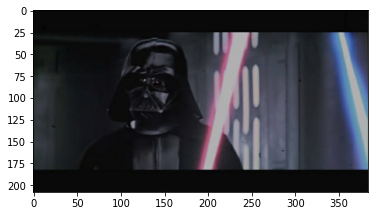

TRAIN GROUND TRUTH:


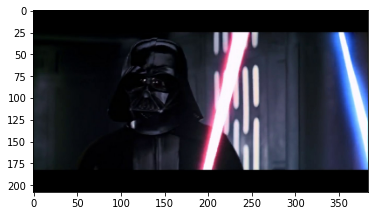

In [ ]:
# we print the paired images of the zipped train dataset for verification
print('MODEL TRAIN INPUT:')
plt.imshow(train.as_numpy_iterator().next()[0][4])
plt.show()
print('TRAIN GROUND TRUTH:')
plt.imshow(train.as_numpy_iterator().next()[1][4])
plt.show()

In [ ]:
# We use the Evaluation metrics to see how different the input and ground truth 
print('Evaluation metrics for train ground truth and model train input:')
print(f'PCNR: {PSNR(train.as_numpy_iterator().next()[0][4], train.as_numpy_iterator().next()[1][4])}')
print(f'SSIM: {SSIM(train.as_numpy_iterator().next()[0][4], train.as_numpy_iterator().next()[1][4])}')
print(f'MSE: {MSE(train.as_numpy_iterator().next()[0][4], train.as_numpy_iterator().next()[1][4])}')

Evaluation metrics for train ground truth and model train input:
PCNR: 21.040802001953125
SSIM: 0.6438653469085693
MSE: 0.02360701478809188


In [ ]:
# we use a map function to normalize images
X_val = input_validation.map(lambda X_val: X_val/255.0)

y_val = output_validation.map(lambda y_val: y_val/255.0)

# we zip the input and groundtruth data into a zipped dataset so we can feed it into our model
validation = tf.data.Dataset.zip((X_val, y_val))

In [ ]:
# the max and min pixel value of the input validation images
print(X_val.as_numpy_iterator().next().max(), X_val.as_numpy_iterator().next().min())

0.7566459 0.0


In [ ]:
# the max and min pixel value of the ground truth validation images
print(y_val.as_numpy_iterator().next().max(), y_val.as_numpy_iterator().next().min())

1.0 0.0


In [ ]:
# shape of the input and groundtruth validation data
print(X_val.as_numpy_iterator().next().shape, y_val.as_numpy_iterator().next().shape)

(5, 208, 384, 3) (5, 208, 384, 3)


MODEL VALIDATION INPUT:


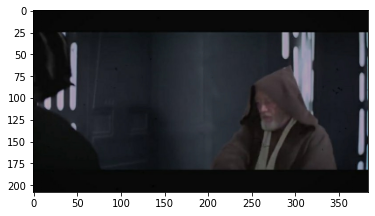

VALIDATION GROUND TRUTH:


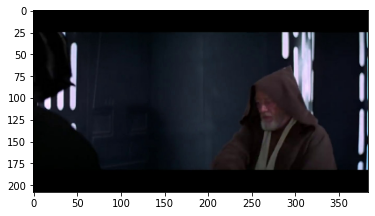

In [ ]:
# we visualize the paired images of the zipped validation dataset for verification
print('MODEL VALIDATION INPUT:')
plt.imshow(validation.as_numpy_iterator().next()[0][3])
plt.show()
print('VALIDATION GROUND TRUTH:')
plt.imshow(validation.as_numpy_iterator().next()[1][3])
plt.show()

In [ ]:
# We use the Evaluation metrics to see how different the input and ground truth 
print('Evaluation metrics for validation ground truth and model validation input:')
print(f'PCNR: {PSNR(validation.as_numpy_iterator().next()[0][3], validation.as_numpy_iterator().next()[1][3])}')
print(f'SSIM: {SSIM(validation.as_numpy_iterator().next()[0][3], validation.as_numpy_iterator().next()[1][3])}')
print(f'MSE: {MSE(validation.as_numpy_iterator().next()[0][3], validation.as_numpy_iterator().next()[1][3])}')

Evaluation metrics for validation ground truth and model validation input:
PCNR: 24.126314163208008
SSIM: 0.6709614396095276
MSE: 0.011600850831571214


Similar to train and validation data, test data are also loaded and preprocessed onto our notebook.

In [ ]:
# directories to the input and output test images
INPUT_TEST = 'mock_model_0.02/input_test_0.02'
OUTPUT_TEST = 'mock_model_0.02/output_test_0.02'

In [ ]:
# loading the test input and output data with .image_dataset_from_directory while changing the image size and batching the data
input_test = tf.keras.utils.image_dataset_from_directory(
    INPUT_TEST,
    labels=None,
    label_mode=None,
    class_names=None,
    color_mode="rgb",
    image_size=image_size,
    batch_size=batch_size,
    shuffle=False)

output_test = tf.keras.utils.image_dataset_from_directory(
    OUTPUT_TEST,
    labels=None,
    label_mode=None,
    color_mode="rgb",
    image_size=image_size,
    batch_size=batch_size,
    shuffle=False)

Found 96 files belonging to 1 classes.
Found 96 files belonging to 1 classes.


In [ ]:
# we use a map function to normalize images
X_test = input_test.map(lambda X_test: X_test/255.0)

y_test = output_test.map(lambda y_test: y_test/255.0)

# we zip the input and groundtruth data into a zipped dataset so we can feed it into our model
test = tf.data.Dataset.zip((X_test, y_test))

In [ ]:
# the max and min pixel value of the input test images
print(X_test.as_numpy_iterator().next().max(), X_test.as_numpy_iterator().next().min())

0.74477917 0.0


In [ ]:
# the max and min pixel value of the output test images
print(y_test.as_numpy_iterator().next().max(), y_test.as_numpy_iterator().next().min())

1.0 0.0


In [ ]:
# shape of the input and output test images
print(X_test.as_numpy_iterator().next().shape, y_test.as_numpy_iterator().next().shape)

(5, 208, 384, 3) (5, 208, 384, 3)


MODEL TEST OUTPUT:


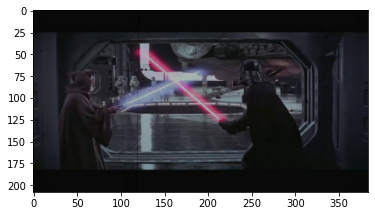

TEST GROUND TRUTH:


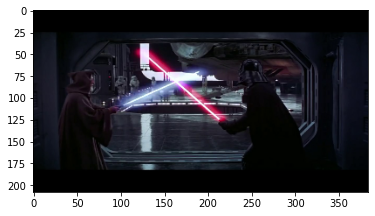

In [ ]:
# we visualize the paired images of the zipped test dataset for verification
print('MODEL TEST OUTPUT:')
plt.imshow(test.as_numpy_iterator().next()[0][3])
plt.show()
print('TEST GROUND TRUTH:')
plt.imshow(test.as_numpy_iterator().next()[1][3])
plt.show()

In [7]:
input = layers.Input(shape=(208, 384, 3))

# Encoder
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(input)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)

# Decoder
x = layers.Conv2DTranspose(128, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(3, (3, 3), activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(3, (3, 3), activation="relu", padding="same")(x)

autoencoder = Model(input, x)

In [ ]:
autoencoder.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 208, 384, 3)]     0         
                                                                 
 conv2d_15 (Conv2D)          (None, 208, 384, 32)      896       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 104, 192, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 104, 192, 64)      18496     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 52, 96, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 52, 96, 64)        3692

In [8]:
autoencoder.compile(optimizer = Adam(learning_rate = 1e-4), 
               loss = 'mean_squared_error',
               metrics = [PSNR, SSIM])

We run the more complicated model with the train and validation data for 100 epochs.

In [ ]:
history1 = autoencoder.fit(train,
                           epochs=100,
                           validation_data= validation,
                           verbose=1)

Epoch 1/100
92/92 [==============================] - 134s 1s/step - loss: 0.0536 - PSNR: 14.9502 - SSIM: 0.2261 - val_loss: 0.0351 - val_PSNR: 15.3449 - val_SSIM: 0.1368
Epoch 2/100
92/92 [==============================] - 5s 59ms/step - loss: 0.0237 - PSNR: 17.6499 - SSIM: 0.3154 - val_loss: 0.0328 - val_PSNR: 15.5609 - val_SSIM: 0.3198
Epoch 3/100
92/92 [==============================] - 5s 56ms/step - loss: 0.0167 - PSNR: 19.0585 - SSIM: 0.4477 - val_loss: 0.0244 - val_PSNR: 16.9122 - val_SSIM: 0.4160
Epoch 4/100
92/92 [==============================] - 6s 64ms/step - loss: 0.0147 - PSNR: 19.5432 - SSIM: 0.4797 - val_loss: 0.0197 - val_PSNR: 17.8549 - val_SSIM: 0.4508
Epoch 5/100
92/92 [==============================] - 5s 58ms/step - loss: 0.0137 - PSNR: 19.8625 - SSIM: 0.4942 - val_loss: 0.0170 - val_PSNR: 18.5298 - val_SSIM: 0.4699
Epoch 6/100
92/92 [==============================] - 6s 63ms/step - loss: 0.0129 - PSNR: 20.1585 - SSIM: 0.5060 - val_loss: 0.0149 - val_PSNR: 19.1572

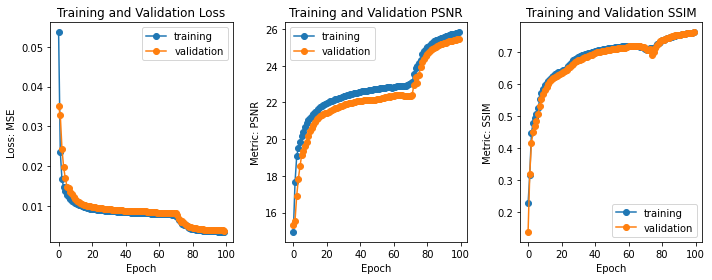

In [ ]:
plt.subplots(1,3,figsize =(10,4))

plt.subplot(1,3,1)
plt.plot(history1.history['loss'], marker='o', label='training')
plt.plot(history1.history['val_loss'], marker='o', label='validation')

plt.title('Training and Validation Loss')
plt.legend(loc='best')
plt.xlabel('Epoch')
plt.ylabel('Loss: MSE')

plt.subplot(1,3,2)
plt.plot(history1.history['PSNR'], marker='o', label='training')
plt.plot(history1.history['val_PSNR'], marker='o', label='validation')
plt.title('Training and Validation PSNR')
plt.legend(loc='best')
plt.xlabel('Epoch')
plt.ylabel('Metric: PSNR')


plt.subplot(1,3,3)
plt.plot(history1.history['SSIM'], marker='o', label='training')
plt.plot(history1.history['val_SSIM'], marker='o', label='validation')
plt.title('Training and Validation SSIM')
plt.legend(loc='best')
plt.xlabel('Epoch')
plt.ylabel('Metric: SSIM')
plt.tight_layout()
plt.show()

As the model is trained in each epoch, the MSE decreases while the PSNR and SSIM increase. Which is a positive sign and shows that the reconstruced image is getting more similar to the ground truth.

However, no divergence is observed in the graphs for the train and validation data. SInce the model has a high number of trainable parameters we can assume that the model is underfit.

We will visualize the outputs of the model for an individual train and test image and compare them to their respective ground truth images using the metrics we have defined.

In [ ]:
# get the model predictions for the input training data
train_predictions = autoencoder.predict(X_train)

92/92 [==============================] - 4s 44ms/step


In [ ]:
# max and min value for the reconstructed images
print(train_predictions.max(), train_predictions.min())

1.4231465 0.0


TRAIN GROUND TRUTH:


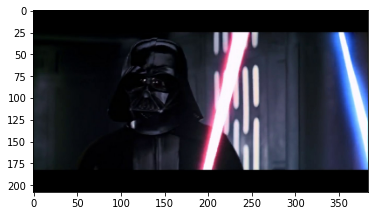

MODEL TRAIN OUTPUT:


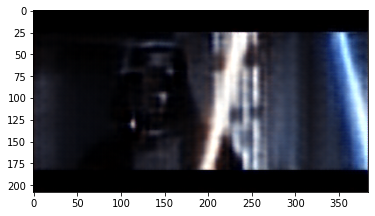

In [ ]:
# visualize the train ground truth and the model train output
print('TRAIN GROUND TRUTH:')
plt.imshow(train.as_numpy_iterator().next()[1][4])
plt.show()
print('MODEL TRAIN OUTPUT:')
plt.imshow(train_predictions[4])
plt.show()

In [ ]:
print('Evaluation metrics for train ground truth and model train output:')
print(f'PCNR: {PSNR(train.as_numpy_iterator().next()[1][4], train_predictions[4])}')
print(f'SSIM: {SSIM(train.as_numpy_iterator().next()[1][4], train_predictions[4])}')
print(f'MSE: {MSE(train.as_numpy_iterator().next()[1][4], train_predictions[4])}')

Evaluation metrics for train ground truth and model train output:
PCNR: 24.76106834411621
SSIM: 0.8199830055236816
MSE: 0.010023380483798782


It is visible that the model is underfit since the all colors are not learned properly by the model and the reconstructed image is quite blur. These observations are backed up by the evaluation  metrics, especially MSE, which is not as low as we want it to be.

We will now evaluate the model performance for the test data:

In [ ]:
# evaluate the model performance for the test data
autoencoder.evaluate(test, verbose=1)

20/20 [==============================] - 36s 2s/step - loss: 0.0035 - PSNR: 25.6924 - SSIM: 0.7627


[0.003465736284852028, 25.69240379333496, 0.7627378106117249]

The summary for this trained model is as below:

| | MSE | PSNR | SSIM |
|---------|---------|-----------|--------------|
|Train |  0.0035    |   25.82    |  0.7628          |
|Validation   |   0.0038    |    25.46     |  0.7631          |
|Test  |   0.0035    |    25.69     |  0.7627         |


In [ ]:
# get the model predictions of the test input data
test_predictions = autoencoder.predict(X_test)

20/20 [==============================] - 1s 24ms/step


In [ ]:
# get the shape of the reconstructed test data
test_predictions.shape

(96, 208, 384, 3)

In [ ]:
print(test_predictions.max(), test_predictions.min())

1.3389797 0.0


TEST GROUND TRUTH:


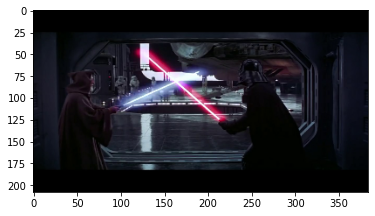

MODEL TEST OUTPUT:


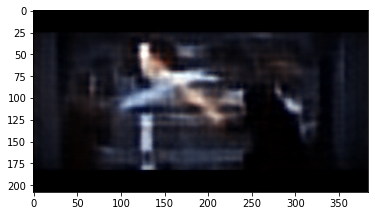

In [ ]:
# visualize the test ground truth and the model test output
print('TEST GROUND TRUTH:')
plt.imshow(test.as_numpy_iterator().next()[1][3])
plt.show()
print('MODEL TEST OUTPUT:')
plt.imshow(test_predictions[3])
plt.show()

In [ ]:
print('Evaluation metrics for test ground truth and model test output:')
print(f'PCNR: {PSNR(test.as_numpy_iterator().next()[1][3], test_predictions[3])}')
print(f'SSIM: {SSIM(test.as_numpy_iterator().next()[1][3], test_predictions[3])}')
print(f'MSE: {MSE(test.as_numpy_iterator().next()[1][3], test_predictions[3])}')

Evaluation metrics for test ground truth and model test output:
PCNR: 23.302825927734375
SSIM: 0.6864857077598572
MSE: 0.01402292867710374


Based on the evaluation metric values and the recinstructed images, we decided to run the model for 200 epochs to see if the performance of the model will improve.

In [ ]:
history1_2 = autoencoder.fit(train,
                           epochs=200,
                           validation_data= validation,
                           verbose=1)

Epoch 1/200
92/92 [==============================] - 8s 70ms/step - loss: 0.0502 - PSNR: 15.2864 - SSIM: 0.2722 - val_loss: 0.0294 - val_PSNR: 15.9497 - val_SSIM: 0.2460
Epoch 2/200
92/92 [==============================] - 6s 61ms/step - loss: 0.0222 - PSNR: 17.8266 - SSIM: 0.3797 - val_loss: 0.0196 - val_PSNR: 17.8645 - val_SSIM: 0.4347
Epoch 3/200
92/92 [==============================] - 6s 60ms/step - loss: 0.0148 - PSNR: 19.5055 - SSIM: 0.4854 - val_loss: 0.0158 - val_PSNR: 18.8478 - val_SSIM: 0.4803
Epoch 4/200
92/92 [==============================] - 6s 66ms/step - loss: 0.0136 - PSNR: 19.8872 - SSIM: 0.5006 - val_loss: 0.0144 - val_PSNR: 19.3092 - val_SSIM: 0.4949
Epoch 5/200
92/92 [==============================] - 6s 63ms/step - loss: 0.0129 - PSNR: 20.1519 - SSIM: 0.5118 - val_loss: 0.0133 - val_PSNR: 19.6977 - val_SSIM: 0.5085
Epoch 6/200
92/92 [==============================] - 6s 66ms/step - loss: 0.0123 - PSNR: 20.3897 - SSIM: 0.5267 - val_loss: 0.0126 - val_PSNR: 20.0080

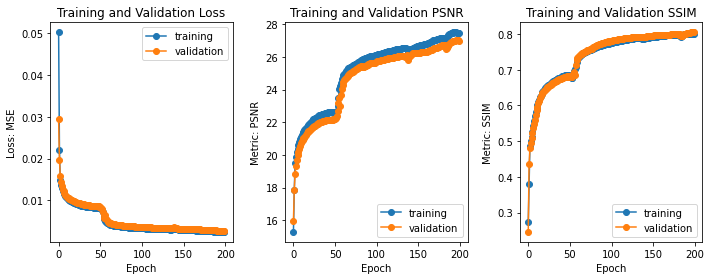

In [ ]:
plt.subplots(1,3,figsize =(10,4))

plt.subplot(1,3,1)
plt.plot(history1_2.history['loss'], marker='o', label='training')
plt.plot(history1_2.history['val_loss'], marker='o', label='validation')

plt.title('Training and Validation Loss')
plt.legend(loc='best')
plt.xlabel('Epoch')
plt.ylabel('Loss: MSE')

plt.subplot(1,3,2)
plt.plot(history1_2.history['PSNR'], marker='o', label='training')
plt.plot(history1_2.history['val_PSNR'], marker='o', label='validation')
plt.title('Training and Validation PSNR')
plt.legend(loc='best')
plt.xlabel('Epoch')
plt.ylabel('Metric: PSNR')


plt.subplot(1,3,3)
plt.plot(history1_2.history['SSIM'], marker='o', label='training')
plt.plot(history1_2.history['val_SSIM'], marker='o', label='validation')
plt.title('Training and Validation SSIM')
plt.legend(loc='best')
plt.xlabel('Epoch')
plt.ylabel('Metric: SSIM')
plt.tight_layout()
plt.show()

After training the same model with the same dataset but this time for 200 epochs, we observe the same trend for the evaluation metrics. As the model goes through the epochs, the MSE decreases and the PSNR and SSIM increase.

For the 2% sample dataset, after training the model for 100 and 200 epochs the model evaluation metrics for the training and validation images are as below:


**Training images:**

| | MSE | PSNR | SSIM |
|---------|---------|-----------|--------------|
|Model trained for 100 epochs |      0.0035    |   25.823    |  0.7628    |
|Model trained for 200 epochs   |        0.0025    |    27.456     |  0.8007       |


**Validation images:**

| | MSE | PSNR | SSIM |
|---------|---------|-----------|--------------|
|Model trained for 100 epochs |    0.0038    |   25.46    |  0.7631      |
|Model trained for 200 epochs   |    0.0027    |    27.00     |  0.8048           |

**We observe a significant improvement in the loss and evaluation metrics after we train the model for an additional 100 epochs.** However, even the improved values are still not good values for reconstructed images and are not comparable to the values we obtained with our smaller structure. **The difference is understandable since this model has more than 374,000 parameters to learn and will take much longer (higher number of epochs) to be fully trained.**



In [ ]:
# we will get the predictions of the test input 
train_predictions = autoencoder.predict(X_train)

92/92 [==============================] - 2s 22ms/step


In [ ]:
# max and min value for the reconstructed images
print(train_predictions.max(), train_predictions.min())

1.4231465 0.0


TRAIN GROUND TRUTH:


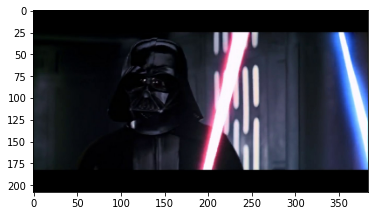

MODEL TRAIN OUTPUT:


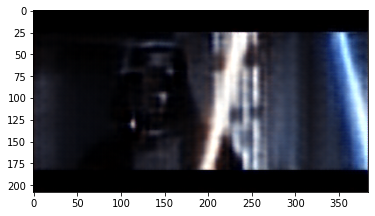

In [ ]:
# visualize the groud truth and model output for a train image
print('TRAIN GROUND TRUTH:')
plt.imshow(train.as_numpy_iterator().next()[1][4])
plt.show()
print('MODEL TRAIN OUTPUT:')
plt.imshow(train_predictions[4])
plt.show()

In [ ]:
print('Evaluation metrics for train ground truth and model train output:')
print(f'PCNR: {PSNR(train.as_numpy_iterator().next()[1][4], test_predictions[4])}')
print(f'SSIM: {SSIM(train.as_numpy_iterator().next()[1][4], test_predictions[4])}')
print(f'MSE: {MSE(train.as_numpy_iterator().next()[1][4], test_predictions[4])}')

Evaluation metrics for train ground truth and model train output:
PCNR: 26.81632423400879
SSIM: 0.8520985245704651
MSE: 0.006244371264807138


In [ ]:
# evaluate the model performance for the test data
autoencoder.evaluate(test, verbose=1)

20/20 [==============================] - 2s 71ms/step - loss: 0.0025 - PSNR: 27.1067 - SSIM: 0.7971


[0.002545083174481988, 27.106657028198242, 0.7970865368843079]

The summary for this trained model is as below:

| | MSE | PSNR | SSIM |
|---------|---------|-----------|--------------|
|Train |    0.0025    |    27.456     |  0.8007         |
|Validation   |   0.0027    |    27.00     |  0.8048          |
|Test  |   0.0025    |    27.11     |  0.7971        |




In [ ]:
# get the model predictions of the test input data
test_predictions = autoencoder.predict(X_test)

20/20 [==============================] - 0s 20ms/step


TEST GROUND TRUTH:


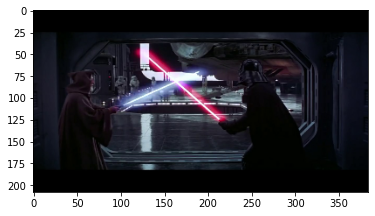

MODEL TEST OUTPUT:


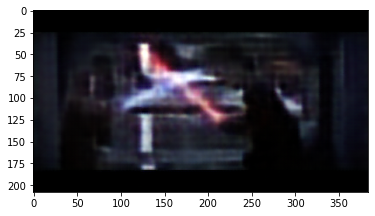

In [ ]:
# visualize the test ground truth and the model test output
print('TEST GROUND TRUTH:')
plt.imshow(test.as_numpy_iterator().next()[1][3])
plt.show()
print('MODEL TEST OUTPUT:')
plt.imshow(test_predictions[3])
plt.show()

In [ ]:
print('Evaluation metrics for test ground truth and model test output:')
print(f'PCNR: {PSNR(test.as_numpy_iterator().next()[1][3], test_predictions[3])}')
print(f'SSIM: {SSIM(test.as_numpy_iterator().next()[1][3], test_predictions[3])}')
print(f'MSE: {MSE(test.as_numpy_iterator().next()[1][3], test_predictions[3])}')

Evaluation metrics for test ground truth and model test output:
PCNR: 23.966476440429688
SSIM: 0.7165386080741882
MSE: 0.012035759180757043


## Loading, Preprocessing and Modeling 12% of the Dataset

In this section we will train the same model as before, but on 12% of the data which amounts to 3816 paired images. Similar to before, we will set aside 15% of the data points for testing, and divide the remaining data points between validation and train images, with 85% as train and 15% as validation data points.

The link to this dataset: https://drive.google.com/file/d/1GvIiE7RYqHZFKYonVhSNAgZoztjcotFG/view?usp=sharing

In [ ]:
# we unzip the file containing the 12% dataset
!unzip '/content/gdrive/My Drive/mock_model_0.12'

Streaming output truncated to the last 5000 lines.
  inflating: __MACOSX/output_train_0.12/._0000003168.jpg  
  inflating: output_train_0.12/0000019130.jpg  
  inflating: __MACOSX/output_train_0.12/._0000019130.jpg  
  inflating: output_train_0.12/0000006776.jpg  
  inflating: __MACOSX/output_train_0.12/._0000006776.jpg  
  inflating: output_train_0.12/0000014372.jpg  
  inflating: __MACOSX/output_train_0.12/._0000014372.jpg  
  inflating: output_train_0.12/0000008773.jpg  
  inflating: __MACOSX/output_train_0.12/._0000008773.jpg  
  inflating: output_train_0.12/0000027790.jpg  
  inflating: __MACOSX/output_train_0.12/._0000027790.jpg  
  inflating: output_train_0.12/0000001743.jpg  
  inflating: __MACOSX/output_train_0.12/._0000001743.jpg  
  inflating: output_train_0.12/0000013421.jpg  
  inflating: __MACOSX/output_train_0.12/._0000013421.jpg  
  inflating: output_train_0.12/0000014819.jpg  
  inflating: __MACOSX/output_train_0.12/._0000014819.jpg  
  inflating: output_train_0.12/000

In [ ]:
cd '/content/'

/content/gdrive/MyDrive


In [9]:
# directories to the train and validation input and output datasets
INPUT_TRAIN = 'input_train_0.12'
INPUT_VAL = 'input_val_0.12'

OUTPUT_TRAIN = 'output_train_0.12'
OUTPUT_VAL = 'output_val_0.12'

In [10]:
# we specify the batch size and traget image size
batch_size = 10
image_size = (208, 384)

In [11]:
# loading the train and validation data with .image_dataset_from_directory while changing the image size and batching the data
input_train = tf.keras.utils.image_dataset_from_directory(
    INPUT_TRAIN,
    labels=None,
    label_mode=None,
    class_names=None,
    color_mode="rgb",
    image_size=image_size,
    batch_size=batch_size,
    shuffle=False)

input_validation = tf.keras.utils.image_dataset_from_directory(
    INPUT_VAL,
    labels=None,
    label_mode=None,
    color_mode="rgb",
    image_size=image_size,
    batch_size=batch_size,
    shuffle=False)

Found 2755 files belonging to 1 classes.
Found 486 files belonging to 1 classes.


In [12]:
# we have different generators for the outputs (groundtruth) of the train and validation data
output_train = tf.keras.utils.image_dataset_from_directory(
    OUTPUT_TRAIN,
    labels=None,
    label_mode=None,
    class_names=None,
    batch_size=batch_size,
    color_mode="rgb",
    image_size=image_size,
    shuffle=False)

output_validation = tf.keras.utils.image_dataset_from_directory(
    OUTPUT_VAL,
    labels=None,
    label_mode=None,
    class_names=None,
    batch_size=batch_size,
    color_mode="rgb",
    image_size=image_size,
    shuffle=False)

Found 2755 files belonging to 1 classes.
Found 486 files belonging to 1 classes.


In [13]:
# we use a map function to normalize images
X_train = input_train.map(lambda X_train: X_train/255.0)

y_train = output_train.map(lambda y_train: y_train/255.0)

# we zip the input and groundtruth data into a zipped dataset so we can feed it into our model
train = tf.data.Dataset.zip((X_train, y_train))

In [ ]:
# the max and min pixel value of the input train images
print(X_train.as_numpy_iterator().next().max(), X_train.as_numpy_iterator().next().min())

0.7209391 0.0


In [ ]:
# the max and min pixel value of the ground truth train images
print(y_train.as_numpy_iterator().next().max(), y_train.as_numpy_iterator().next().min())

1.0 0.0


In [ ]:
# shape of the input and groundtruth train data
print(X_train.as_numpy_iterator().next().shape, y_train.as_numpy_iterator().next().shape)

(10, 212, 380, 3) (10, 212, 380, 3)


MODEL TRAIN INPUT:


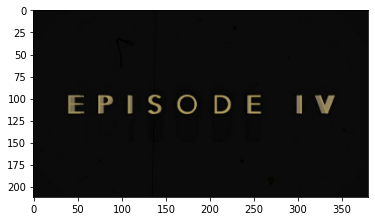

TRAIN GROUND TRUTH:


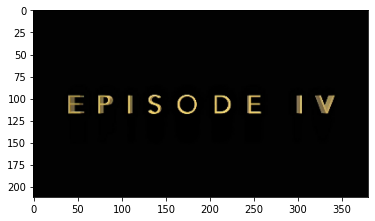

In [ ]:
# we visualize the paired images of the zipped train dataset for verification
print('MODEL TRAIN INPUT:')
plt.imshow(train.as_numpy_iterator().next()[0][9])
plt.show()
print('TRAIN GROUND TRUTH:')
plt.imshow(train.as_numpy_iterator().next()[1][9])
plt.show()

In [ ]:
# We use the Evaluation metrics to see how different the input and ground truth
print('Evaluation metrics for train ground truth and model train input:')
print(f'PCNR: {PSNR(train.as_numpy_iterator().next()[0][9], train.as_numpy_iterator().next()[1][9])}')
print(f'SSIM: {SSIM(train.as_numpy_iterator().next()[0][9], train.as_numpy_iterator().next()[1][9])}')
print(f'MSE: {MSE(train.as_numpy_iterator().next()[0][9], train.as_numpy_iterator().next()[1][9])}')

Evaluation metrics for train ground truth and model train input:
PCNR: 28.00557518005371
SSIM: 0.3881444036960602
MSE: 0.004748579777308319


In [14]:
# we use a map function to normalize images
X_val = input_validation.map(lambda X_val: X_val/255.0)

y_val = output_validation.map(lambda y_val: y_val/255.0)

# we zip the input and groundtruth data into a zipped dataset so we can feed it into our model
validation = tf.data.Dataset.zip((X_val, y_val))

In [ ]:
# the max and min pixel value of the input validation images
print(X_val.as_numpy_iterator().next().max(), X_val.as_numpy_iterator().next().min())

0.75134116 0.0


In [ ]:
# the max and min pixel value of the ground truth validation images
print(y_val.as_numpy_iterator().next().max(), y_val.as_numpy_iterator().next().min())

1.0 0.0


In [ ]:
# shape of the input and groundtruth validation data
print(X_val.as_numpy_iterator().next().shape, y_val.as_numpy_iterator().next().shape)

(10, 212, 380, 3) (10, 212, 380, 3)


MODEL VALIDATION BINPUT:


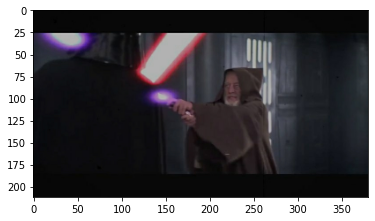

VALIDATION GROUND TRUTH:


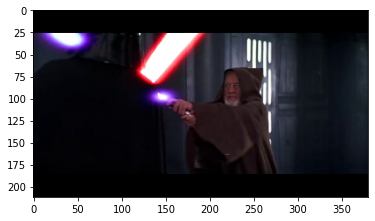

In [ ]:
# we visualize the paired images of the zipped validation dataset for verification
print('MODEL VALIDATION INPUT:')
plt.imshow(validation.as_numpy_iterator().next()[0][8])
plt.show()
print('VALIDATION GROUND TRUTH:')
plt.imshow(validation.as_numpy_iterator().next()[1][8])
plt.show()

In [ ]:
print('Evaluation metrics for validation ground truth and model validation input:')
print(f'PCNR: {PSNR(validation.as_numpy_iterator().next()[0][8], validation.as_numpy_iterator().next()[1][8])}')
print(f'SSIM: {SSIM(validation.as_numpy_iterator().next()[0][8], validation.as_numpy_iterator().next()[1][8])}')
print(f'MSE: {MSE(validation.as_numpy_iterator().next()[0][8], validation.as_numpy_iterator().next()[1][8])}')

Evaluation metrics for validation ground truth and model validation input:
PCNR: 22.953861236572266
SSIM: 0.6458683013916016
MSE: 0.015196195752215215


In [ ]:
# directories to the input and output test images
INPUT_TEST = 'input_test_0.12'
OUTPUT_TEST = 'output_test_0.12'

In [ ]:
# loading the test input and output data with .image_dataset_from_directory while changing the image size and batching the data
input_test = tf.keras.utils.image_dataset_from_directory(
    INPUT_TEST,
    labels=None,
    label_mode=None,
    class_names=None,
    color_mode="rgb",
    image_size=image_size,
    batch_size=batch_size,
    shuffle=False)

output_test = tf.keras.utils.image_dataset_from_directory(
    OUTPUT_TEST,
    labels=None,
    label_mode=None,
    color_mode="rgb",
    image_size=image_size,
    batch_size=batch_size,
    shuffle=False)

Found 573 files belonging to 1 classes.
Found 573 files belonging to 1 classes.


In [ ]:
# we use a map function to normalize images
X_test = input_test.map(lambda X_test: X_test/255.0)

y_test = output_test.map(lambda y_test: y_test/255.0)

# we zip the input and groundtruth data into a zipped dataset so we can feed it into our model
test = tf.data.Dataset.zip((X_test, y_test))

MODEL TEST INPUT:


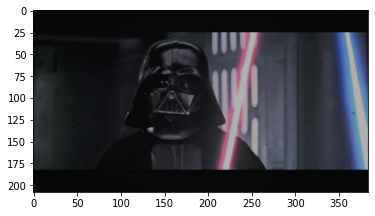

TEST GROUND TRUTH:


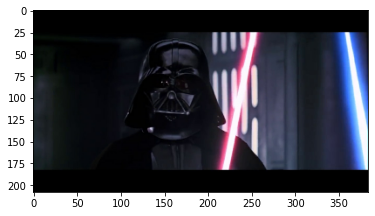

In [ ]:
print('MODEL TEST INPUT:')
plt.imshow(test.as_numpy_iterator().next()[0][5])
plt.show()
print('TEST GROUND TRUTH:')
plt.imshow(test.as_numpy_iterator().next()[1][5])
plt.show()

In [ ]:
print('Evaluation metrics for test ground truth and model test input:')
print(f'PCNR: {PSNR(test.as_numpy_iterator().next()[0][5], test.as_numpy_iterator().next()[1][5])}')
print(f'SSIM: {SSIM(test.as_numpy_iterator().next()[0][5], test.as_numpy_iterator().next()[1][5])}')
print(f'MSE: {MSE(test.as_numpy_iterator().next()[0][5], test.as_numpy_iterator().next()[1][5])}')

Evaluation metrics for test ground truth and model test input:
PCNR: 22.019044876098633
SSIM: 0.6623950004577637
MSE: 0.018845892231538174


We run the same model but this time with 12% of the dataset for 100 epochs.

In [ ]:
history2 = autoencoder.fit(train,
                           epochs=100,
                           validation_data= validation,
                           verbose=1)

Epoch 1/100
276/276 [==============================] - 38s 128ms/step - loss: 0.0285 - PSNR: 17.3158 - SSIM: 0.3630 - val_loss: 0.0230 - val_PSNR: 17.6945 - val_SSIM: 0.4619
Epoch 2/100
276/276 [==============================] - 38s 136ms/step - loss: 0.0133 - PSNR: 19.8926 - SSIM: 0.5067 - val_loss: 0.0168 - val_PSNR: 19.0307 - val_SSIM: 0.5111
Epoch 3/100
276/276 [==============================] - 44s 158ms/step - loss: 0.0115 - PSNR: 20.6276 - SSIM: 0.5527 - val_loss: 0.0145 - val_PSNR: 19.7260 - val_SSIM: 0.5586
Epoch 4/100
276/276 [==============================] - 31s 110ms/step - loss: 0.0105 - PSNR: 21.0942 - SSIM: 0.5913 - val_loss: 0.0135 - val_PSNR: 20.0443 - val_SSIM: 0.5807
Epoch 5/100
276/276 [==============================] - 32s 115ms/step - loss: 0.0100 - PSNR: 21.3397 - SSIM: 0.6099 - val_loss: 0.0130 - val_PSNR: 20.2554 - val_SSIM: 0.5963
Epoch 6/100
276/276 [==============================] - 39s 141ms/step - loss: 0.0097 - PSNR: 21.5286 - SSIM: 0.6248 - val_loss: 0.

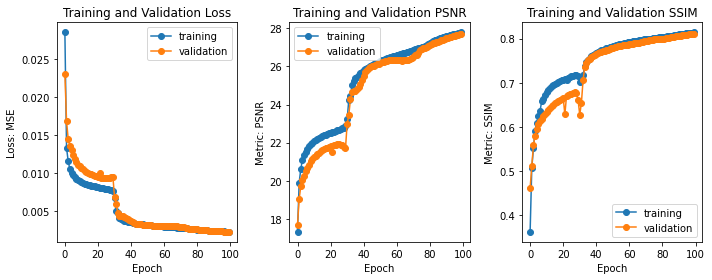

In [ ]:
plt.subplots(1,3,figsize =(10,4))

plt.subplot(1,3,1)
plt.plot(history2.history['loss'], marker='o', label='training')
plt.plot(history2.history['val_loss'], marker='o', label='validation')

plt.title('Training and Validation Loss')
plt.legend(loc='best')
plt.xlabel('Epoch')
plt.ylabel('Loss: MSE')

plt.subplot(1,3,2)
plt.plot(history2.history['PSNR'], marker='o', label='training')
plt.plot(history2.history['val_PSNR'], marker='o', label='validation')
plt.title('Training and Validation PSNR')
plt.legend(loc='best')
plt.xlabel('Epoch')
plt.ylabel('Metric: PSNR')


plt.subplot(1,3,3)
plt.plot(history2.history['SSIM'], marker='o', label='training')
plt.plot(history2.history['val_SSIM'], marker='o', label='validation')
plt.title('Training and Validation SSIM')
plt.legend(loc='best')
plt.xlabel('Epoch')
plt.ylabel('Metric: SSIM')
plt.tight_layout()
plt.show()

We can compare the performance of the models on the train and validation images after training for 100 epochs for the 2% and 12% sample datasets:


**Training images:**

| | MSE | PSNR | SSIM |
|---------|---------|-----------|--------------|
|2% Sample dataset |   0.0035    |   25.82    |  0.7628              |
|12% Sample dataset  |   0.0023    |    27.79    |  0.8141          |


**Validation images:**

| | MSE | PSNR | SSIM |
|---------|---------|-----------|--------------|
|2% Sample dataset |   0.0038    |    25.46     |  0.7631       |
|12% Sample dataset   |   0.0023    |    27.72     |  0.8109         |


**Significant improvements are observed as we increase the number of train and validation data for our model.**

To visualize how to the model is performing on the training images, we visualize the output of the model for a training image and compare it to the ground truth.


In [ ]:
# get the model predictions for the input training data
train_predictions = autoencoder.predict(X_train)

276/276 [==============================] - 11s 41ms/step


TRAIN GROUND TRUTH:


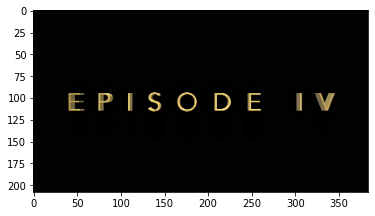

MODEL TRAIN OUTPUT:


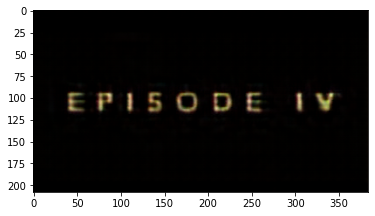

In [ ]:
print('TRAIN GROUND TRUTH:')
plt.imshow(train.as_numpy_iterator().next()[1][9])
plt.show()
print('MODEL TRAIN OUTPUT:')
plt.imshow(train_predictions[9])
plt.show()

In [ ]:
print('Evaluation metrics for train ground truth and model train output:')
print(f'PCNR: {PSNR(train.as_numpy_iterator().next()[1][9], train_predictions[5])}')
print(f'SSIM: {SSIM(train.as_numpy_iterator().next()[1][9], train_predictions[9])}')
print(f'MSE: {MSE(train.as_numpy_iterator().next()[1][9], train_predictions[9])}')

Evaluation metrics for train ground truth and model train output:
PCNR: 27.443269729614258
SSIM: 0.7868902087211609
MSE: 0.005069377497772634


In [ ]:
# evaluate the model performance for the test data
autoencoder.evaluate(test, verbose=1)

58/58 [==============================] - 6s 99ms/step - loss: 0.0023 - PSNR: 27.6720 - SSIM: 0.8097


[0.0023443547543138266, 27.672012329101562, 0.8096799850463867]

The summary for this trained model is as below:

| | MSE | PSNR | SSIM |
|---------|---------|-----------|--------------|
|Train |   0.0023    |    27.79    |  0.8141       |
|Validation   |    0.0023    |    27.72     |  0.8109             |
|Test  |   0.0023    |    27.67     |  0.81        |


We can now compare the performance of the model on the test images after training for 100 epochs for the 2% and 12% sample datasets:


| | MSE | PSNR | SSIM |
|---------|---------|-----------|--------------|
|2% Sample dataset | 0.0035    |    25.69     |  0.7627         |
|12% Sample dataset   |  0.0023    |    27.67     |  0.81             |

Similar to the data we saw for the train and validation images, the model performance improves significantly when it is fed more data.

In [ ]:
# get the model predictions of the test input data
test_predictions = autoencoder.predict(X_test)

58/58 [==============================] - 3s 59ms/step


TEST GROUND TRUTH:


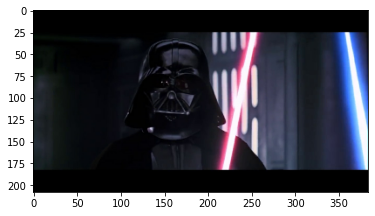

MODEL TEST OUTPUT:


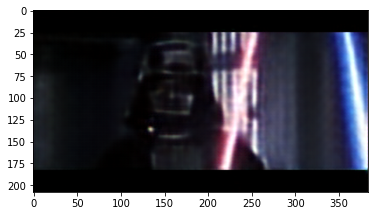

In [ ]:
print('TEST GROUND TRUTH:')
plt.imshow(test.as_numpy_iterator().next()[1][5])
plt.show()
print('MODEL TEST OUTPUT:')
plt.imshow(test_predictions[5])
plt.show()

In [ ]:
print('Evaluation metrics for test ground truth and model test output:')
print(f'PCNR: {PSNR(test.as_numpy_iterator().next()[1][5], test_predictions[5])}')
print(f'SSIM: {SSIM(test.as_numpy_iterator().next()[1][5], test_predictions[5])}')
print(f'MSE: {MSE(test.as_numpy_iterator().next()[1][5], test_predictions[5])}')

Evaluation metrics for test ground truth and model test output:
PCNR: 27.166051864624023
SSIM: 0.8656689524650574
MSE: 0.00576124165770475


In [21]:
# directories to the input and output test images
INPUT_TEST = 'input_test_0.12'
OUTPUT_TEST = 'output_test_0.12'

In [22]:
# loading the test input and output data with .image_dataset_from_directory while changing the image size and batching the data
input_test = tf.keras.utils.image_dataset_from_directory(
    INPUT_TEST,
    labels=None,
    label_mode=None,
    class_names=None,
    color_mode="rgb",
    image_size=image_size,
    batch_size=batch_size,
    shuffle=False)

output_test = tf.keras.utils.image_dataset_from_directory(
    OUTPUT_TEST,
    labels=None,
    label_mode=None,
    color_mode="rgb",
    image_size=image_size,
    batch_size=batch_size,
    shuffle=False)

Found 573 files belonging to 1 classes.
Found 573 files belonging to 1 classes.


In [23]:
# we use a map function to normalize images
X_test = input_test.map(lambda X_test: X_test/255.0)

y_test = output_test.map(lambda y_test: y_test/255.0)

# we zip the input and groundtruth data into a zipped dataset so we can feed it into our model
test = tf.data.Dataset.zip((X_test, y_test))

MODEL TEST INPUT:


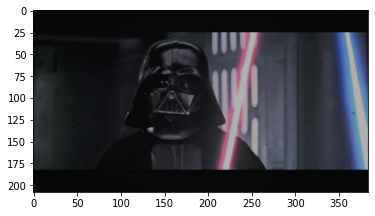

TEST GROUND TRUTH:


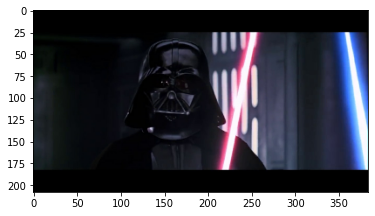

In [24]:
print('MODEL TEST INPUT:')
plt.imshow(test.as_numpy_iterator().next()[0][5])
plt.show()
print('TEST GROUND TRUTH:')
plt.imshow(test.as_numpy_iterator().next()[1][5])
plt.show()

In [25]:
print('Evaluation metrics for test ground truth and model test input:')
print(f'PCNR: {PSNR(test.as_numpy_iterator().next()[0][5], test.as_numpy_iterator().next()[1][5])}')
print(f'SSIM: {SSIM(test.as_numpy_iterator().next()[0][5], test.as_numpy_iterator().next()[1][5])}')
print(f'MSE: {MSE(test.as_numpy_iterator().next()[0][5], test.as_numpy_iterator().next()[1][5])}')

Evaluation metrics for test ground truth and model test input:
PCNR: 22.019044876098633
SSIM: 0.6623950004577637
MSE: 0.018845892231538174


Based on the evaluation metric values and the recinstructed images, we decided to run the model for 200 epochs to see if the performance of the model will improve.

In [15]:
history2_2 = autoencoder.fit(train,
                           epochs=200,
                           validation_data= validation,
                           verbose=1)

Epoch 1/200
276/276 [==============================] - 1635s 6s/step - loss: 0.0280 - PSNR: 17.4170 - SSIM: 0.3532 - val_loss: 0.0235 - val_PSNR: 17.4794 - val_SSIM: 0.4497
Epoch 2/200
276/276 [==============================] - 29s 106ms/step - loss: 0.0134 - PSNR: 19.8765 - SSIM: 0.5131 - val_loss: 0.0175 - val_PSNR: 18.7897 - val_SSIM: 0.5034
Epoch 3/200
276/276 [==============================] - 31s 113ms/step - loss: 0.0115 - PSNR: 20.6450 - SSIM: 0.5552 - val_loss: 0.0153 - val_PSNR: 19.3731 - val_SSIM: 0.5391
Epoch 4/200
276/276 [==============================] - 30s 108ms/step - loss: 0.0106 - PSNR: 21.0741 - SSIM: 0.5903 - val_loss: 0.0142 - val_PSNR: 19.7653 - val_SSIM: 0.5638
Epoch 5/200
276/276 [==============================] - 30s 108ms/step - loss: 0.0100 - PSNR: 21.3411 - SSIM: 0.6107 - val_loss: 0.0137 - val_PSNR: 19.9665 - val_SSIM: 0.5802
Epoch 6/200
276/276 [==============================] - 30s 107ms/step - loss: 0.0097 - PSNR: 21.5464 - SSIM: 0.6276 - val_loss: 0.0

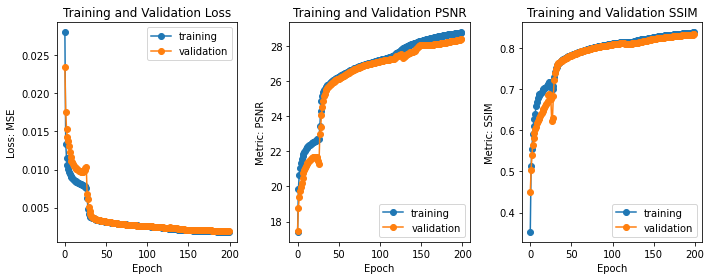

In [16]:
plt.subplots(1,3,figsize =(10,4))

plt.subplot(1,3,1)
plt.plot(history2_2.history['loss'], marker='o', label='training')
plt.plot(history2_2.history['val_loss'], marker='o', label='validation')

plt.title('Training and Validation Loss')
plt.legend(loc='best')
plt.xlabel('Epoch')
plt.ylabel('Loss: MSE')

plt.subplot(1,3,2)
plt.plot(history2_2.history['PSNR'], marker='o', label='training')
plt.plot(history2_2.history['val_PSNR'], marker='o', label='validation')
plt.title('Training and Validation PSNR')
plt.legend(loc='best')
plt.xlabel('Epoch')
plt.ylabel('Metric: PSNR')


plt.subplot(1,3,3)
plt.plot(history2_2.history['SSIM'], marker='o', label='training')
plt.plot(history2_2.history['val_SSIM'], marker='o', label='validation')
plt.title('Training and Validation SSIM')
plt.legend(loc='best')
plt.xlabel('Epoch')
plt.ylabel('Metric: SSIM')
plt.tight_layout()
plt.show()

After trainig the model for 200 epochs we observe that the MSE still decreases while PSNR and SSIM increase as the model goes through the epochs. There is still no sign of over fitting in the graphs, since we dont see a divergence between the train and validation data plots.

For the 12% sample dataset, after training the model for 100 and 200 epochs the model evaluation metrics for the training and validation images are as below:


**Training images:**

| | MSE | PSNR | SSIM |
|---------|---------|-----------|--------------|
|Model trained for 100 epochs | 0.0023    |    27.79    |  0.8141          |
|Model trained for 200 epochs   |   0.0018    |    28.78    |  0.8381          |


**Validation images:**

| | MSE | PSNR | SSIM |
|---------|---------|-----------|--------------|
|Model trained for 100 epochs | 0.0023    |    27.72     |  0.8109             |
|Model trained for 200 epochs   |   0.0019    |    28.40     |  0.8333          |


The model performance increases after we train it for an additional 100 epochs. However, it would be inetersting to compare these results with the 2% sample dataset metrics.


We can compare the performance of the models after training for 200 epochs for the 2% and 12% sample datasets:


**Training images:**

| | MSE | PSNR | SSIM |
|---------|---------|-----------|--------------|
|2% Sample dataset |    0.0025    |    27.456     |  0.8007       |
|12% Sample dataset  |    0.0018    |    28.78    |  0.8381          |


**Validation images:**

| | MSE | PSNR | SSIM |
|---------|---------|-----------|--------------|
|2% Sample dataset |    0.0027    |    27.00     |  0.8048         |
|12% Sample dataset   |   0.0019    |    28.40     |  0.8333            |

We can see that the model performance is better when the number of train and validation images are higher. 

In [17]:
# get the model predictions for the input training data
train_predictions = autoencoder.predict(X_train)

276/276 [==============================] - 12s 41ms/step


TRAIN GROUND TRUTH:


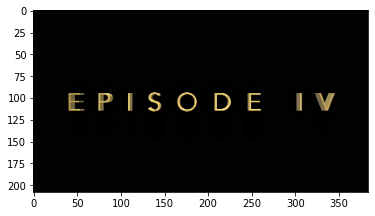

MODEL TRAIN OUTPUT:


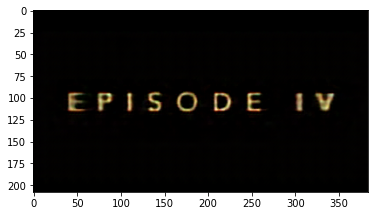

In [18]:
print('TRAIN GROUND TRUTH:')
plt.imshow(train.as_numpy_iterator().next()[1][9])
plt.show()

print('MODEL TRAIN OUTPUT:')
plt.imshow(train_predictions[9])
plt.show()

In [20]:
print('Evaluation metrics for train ground truth and model train output:')
print(f'PCNR: {PSNR(train.as_numpy_iterator().next()[1][9], train_predictions[9])}')
print(f'SSIM: {SSIM(train.as_numpy_iterator().next()[1][9], train_predictions[9])}')
print(f'MSE: {MSE(train.as_numpy_iterator().next()[1][9], train_predictions[9])}')

Evaluation metrics for train ground truth and model train output:
PCNR: 30.07404899597168
SSIM: 0.8669989109039307
MSE: 0.002949280593343592


In [26]:
# evaluate the model performance for the test data
autoencoder.evaluate(test, verbose=1)

58/58 [==============================] - 246s 4s/step - loss: 0.0020 - PSNR: 28.4057 - SSIM: 0.8324


[0.001966495532542467, 28.405656814575195, 0.8324293494224548]

The summary of the model performance after running for 200 epochs is as below:

| | MSE | PSNR | SSIM |
|---------|---------|-----------|--------------|
|Train |   0.0018    |    28.78    |  0.8381              |
|Validation   |   0.0019    |    28.40     |  0.8333        |
|Test  |  0.0020    |    28.41     |  0.8324     |

<br>

We can now compare the performance of the model on the test images after training for 200 epochs for the 2% and 12% sample datasets:


| | MSE | PSNR | SSIM |
|---------|---------|-----------|--------------|
|2% Sample dataset | 0.0025    |    27.11     |  0.7971           |
|12% Sample dataset   |  0.0020    |    28.41     |  0.8324        |

We observe improvements in the model performance for the test data when the number images in the dataset increases.

In [27]:
# get the model predictions of the test input data
test_predictions = autoencoder.predict(X_test)

58/58 [==============================] - 2s 42ms/step


TEST GROUND TRUTH:


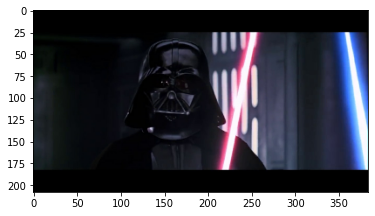

MODEL TEST OUTPUT:


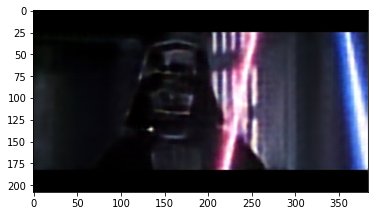

In [28]:
print('TEST GROUND TRUTH:')
plt.imshow(test.as_numpy_iterator().next()[1][5])
plt.show()
print('MODEL TEST OUTPUT:')
plt.imshow(test_predictions[5])
plt.show()

In [29]:
print('Evaluation metrics for test ground truth and model test output:')
print(f'PCNR: {PSNR(test.as_numpy_iterator().next()[1][5], test_predictions[5])}')
print(f'SSIM: {SSIM(test.as_numpy_iterator().next()[1][5], test_predictions[5])}')
print(f'MSE: {MSE(test.as_numpy_iterator().next()[1][5], test_predictions[5])}')

Evaluation metrics for test ground truth and model test output:
PCNR: 28.215139389038086
SSIM: 0.8858994841575623
MSE: 0.0045248815793592825


We will now evaluate the performance of the our model which has been trained on 12% of our dataset for 200 epochs. In order to so, we use a dataset containing low resolution old images, and test our model with these images. 

In [84]:
# directory to the old image test dataset
TEST_IMAGE_DATA = 'test_old_images'

In [85]:
# loading the test data with .image_dataset_from_directory while changing the image size and batching the data
test_image_data = tf.keras.utils.image_dataset_from_directory(
    TEST_IMAGE_DATA,
    labels=None,
    label_mode=None,
    class_names=None,
    color_mode="rgb",
    image_size=image_size,
    batch_size=batch_size,
    shuffle=False)

Found 188 files belonging to 1 classes.


In [86]:
# normalizing the images using map function
test_image = test_image_data.map(lambda test: test/255.0)

TEST INPUT 1:


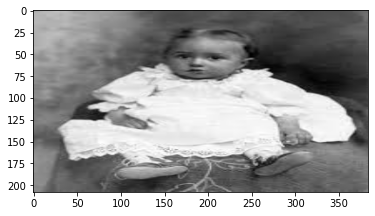

TEST INPUT 2:


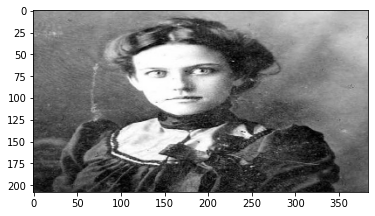

In [103]:
# visualizing 2 random pictures from the dataset
print('TEST INPUT 1:')
plt.imshow(test_image.as_numpy_iterator().next()[8])
plt.show()
print('TEST INPUT 2:')
plt.imshow(test_image.as_numpy_iterator().next()[7])
plt.show()

In [88]:
# passing the images through our data to get the model prediction
test_image_predictions = autoencoder.predict(test_image)

19/19 [==============================] - 2s 116ms/step


MODEL TEST OUTPUT 1:


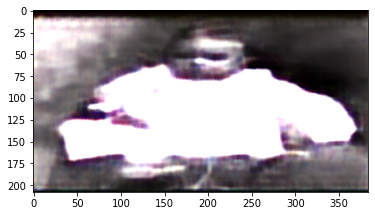

MODEL TEST OUTPUT 2:


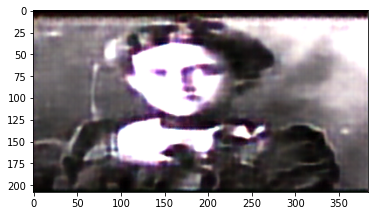

In [104]:
# Visualizing the same two pictures after the model reconstruction
print('MODEL TEST OUTPUT 1:')
plt.imshow(test_image_predictions[8])
plt.show()
print('MODEL TEST OUTPUT 2:')
plt.imshow(test_image_predictions[7])
plt.show()

## Conclusions

- Similar to the previous modeling in Notebook 2, the structure of the model is a convolutional autoencoder.
- The model used in this notebook is more complicated and has 374,406 trainable parameters.
- Due to limited time and computational resources we only train our models on 2% and 12% sample datasets.
- We run the model twice for each sample dataset, once for 100 epochs and once for 200 epochs.
- The best performing model is trained with 12% of the dataset for 200 epochs.
- Contrary to what we observed for the simple structure we had in Notebook 2; the performance of the complicated structure improves by increasing the number of images from 2% to 12% with the same training duration.
- Based on the results from Notebook 2 and 3, when the structure of the model is more complicated and number of trainable parameters is higher, a larger dataset and longer training duration is required.
